# Applied Machine Learning Final Project

**Student:** Jason Ballard

**Course:** CSC 44670-80/81 – Applied Machine Learning

**Date:** April 2025

**Project:** Predicting Medical Charges Using Regression



## Project Overview


## Admin Load Dependencies

In [ ]:
# Standard Library

import os

# Data Handling
import pandas as pd
import numpy as np
from pandas.plotting import scatter_matrix

# Visualization
import seaborn as sns
import matplotlib.pyplot as plt


# Scikit-learn: Model Selection
from sklearn.model_selection import StratifiedShuffleSplit

# Scikit-learn: Models
from sklearn.tree import DecisionTreeClassifier, plot_tree


from sklearn.ensemble import RandomForestClassifier


# Scikit-learn: Preprocessing & Pipeline
from sklearn.preprocessing import LabelEncoder, StandardScaler

from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.tree import DecisionTreeRegressor

# Scikit-learn: Metrics
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    classification_report,
    confusion_matrix, 
    ConfusionMatrixDisplay,
    )





In [ ]:
# Create folder if it doesn't exist
output_dir = "plots"
os.makedirs(output_dir, exist_ok=True)

# Set up visual style
sns.set(style="whitegrid")

## Section 1. Import and Inspect the Data


### 1.1 Load the dataset and display the first 10 rows.


In [ ]:
# Load the dataset
file_path = "data/insurance.csv"
df = pd.read_csv(file_path)

# Display the first 10 rows
df.head(10)

### 1.2 Check for missing values and display summary statistics.


In [ ]:
# Check for missing values
missing_values = df.isnull().sum()

# Display summary statistics
summary_statistics = df.describe(include='all').transpose()

missing_values, summary_statistics

#### Reflection 1:
- _What do you notice about the dataset?_ The data set is clean with no missing values.  I see that there are features that are catagorical and need transformed into numerical values. 

- _Are there any data issues?_ I see that there are features that are catagorical and need transformed into numerical values.


## Section 2. Data Exploration and Preparation

### 2.1 Explore data patterns and distributions
- Create histograms, boxplots, and count plots for categorical variables (as applicable).
- Identify patterns, outliers, and anomalies in feature distributions.
- Check for class imbalance in the target variable (as applicable).

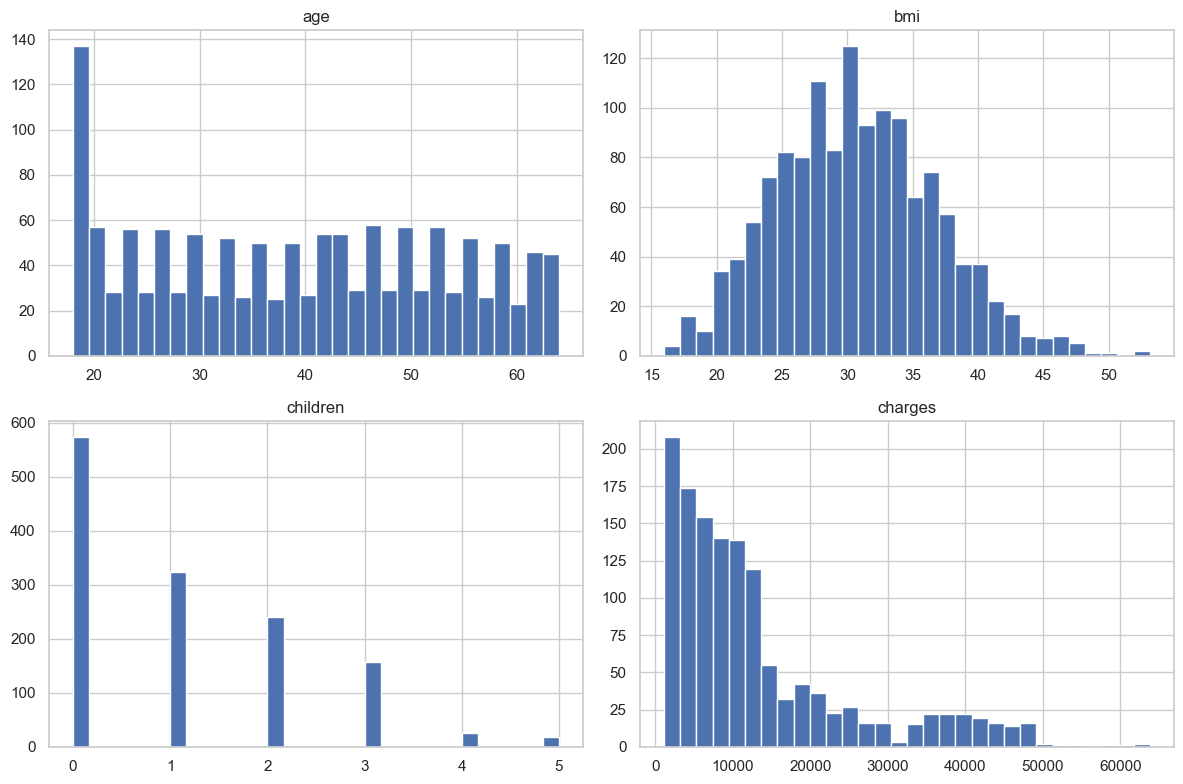

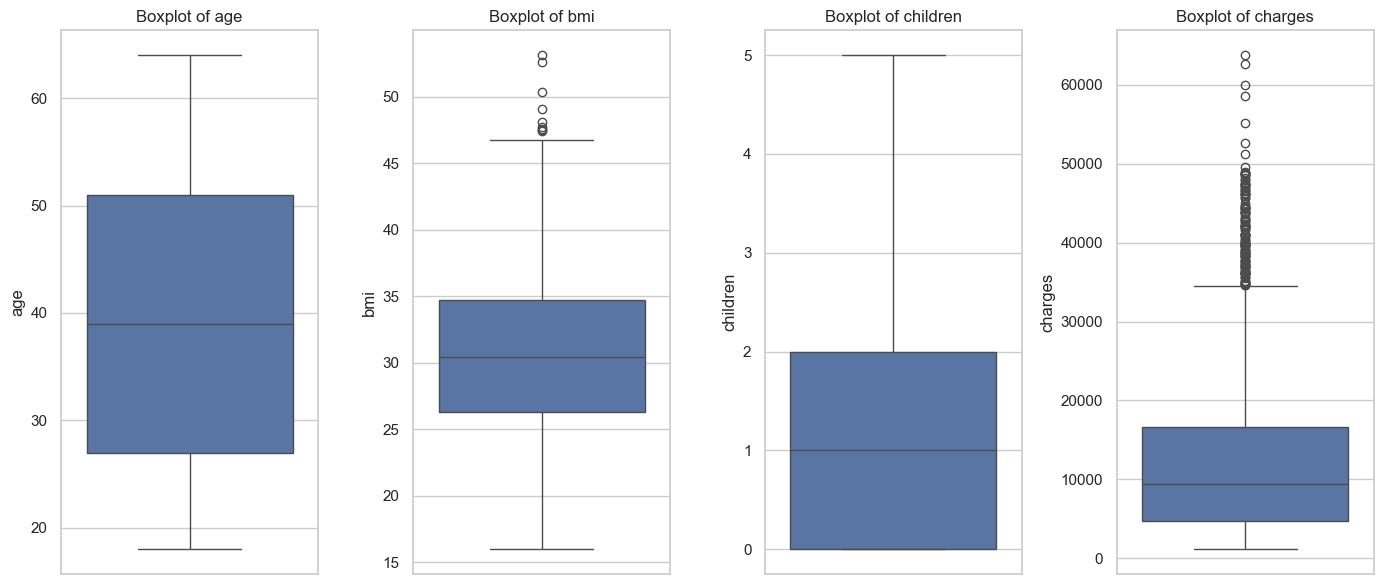

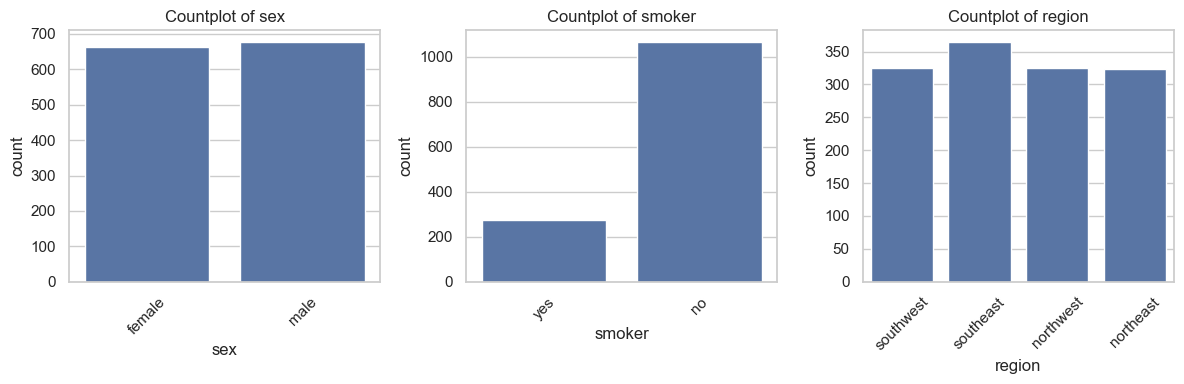

In [53]:
# Histograms for numerical features
df.hist(bins=30, figsize=(12, 8))
plt.tight_layout()
plt.savefig(os.path.join(output_dir, "histograms.png"))
plt.show()

# Boxplots to check for outliers
plt.figure(figsize=(14, 6))
for i, col in enumerate(['age', 'bmi', 'children', 'charges']):
    plt.subplot(1, 4, i+1)
    sns.boxplot(y=df[col])
    plt.title(f'Boxplot of {col}')
plt.tight_layout()
plt.savefig(os.path.join(output_dir, "boxplots.png"))
plt.show()

# Count plots for categorical features
plt.figure(figsize=(12, 4))
for i, col in enumerate(['sex', 'smoker', 'region']):
    plt.subplot(1, 3, i+1)
    sns.countplot(data=df, x=col)
    plt.title(f'Countplot of {col}')
    plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig(os.path.join(output_dir, "countplots.png"))
plt.show()

#### 2.2: Missing Data and Clean Data
- The dataset was already clean with no missing values.
- Categorical variables were identified (`sex`, `smoker`, `region`) and will be converted to numerical values in the next section.
- BMI and charges contain outliers, but instead of removing them, I chose to **clip BMI** and **log-transform charges** to preserve useful signal while reducing skew.

### 2.3 Feature selection and engineering
- Create new features (as applicable).
- Transform or combine existing features to improve model performance (as applicable).
- Scale or normalize data (as applicable).

#### Reflection 2.3:
- I created two engineered features:
  - `bmi_smoker`: Highlights compounded risk from high BMI and smoking.
  - `age_group`: Clusters individuals into life stages for better interpretability.
- I clipped BMI to reduce outlier distortion and log-transformed `charges` to normalize the target distribution.
- I scaled all features to prepare for linear regression and other models sensitive to magnitude differences.
- A Decision Tree Regressor was used to visualize feature importance:
  - `smoker` and `bmi_smoker` ranked highest—strongly associated with insurance charges.
  - This insight guided my final feature selection for model training.

In [55]:
# Run the custom preparation function
def prepare_features(df, transform_target=True, scale=True):
    """Preprocess and engineer features from the insurance dataset."""
    df_encoded = df.copy()

    # Encode categorical variables
    label_encoders = {}
    for col in ['sex', 'smoker', 'region']:
        le = LabelEncoder()
        df_encoded[col] = le.fit_transform(df_encoded[col])
        label_encoders[col] = le

    # Winsorize BMI
    bmi_lower = df_encoded['bmi'].quantile(0.05)
    bmi_upper = df_encoded['bmi'].quantile(0.95)
    df_encoded['bmi'] = df_encoded['bmi'].clip(bmi_lower, bmi_upper)

    # Log-transform charges
    if transform_target:
        df_encoded['charges'] = np.log1p(df_encoded['charges'])

    # Feature engineering
    df_encoded['bmi_smoker'] = df_encoded['bmi'] * df_encoded['smoker']
    df_encoded['age_group'] = pd.cut(df_encoded['age'], bins=[17, 30, 45, 60, 100], labels=[0, 1, 2, 3]).astype(int)

    # Feature and target selection
    feature_cols = ['age', 'bmi', 'children', 'sex', 'smoker', 'region', 'bmi_smoker', 'age_group']
    X = df_encoded[feature_cols]
    y = df_encoded['charges']

    # Scale features
    if scale:
        scaler = StandardScaler()
        X = pd.DataFrame(scaler.fit_transform(X), columns=X.columns)

    return X, y, df_encoded

# Call the function
X, y, df_ready = prepare_features(df)

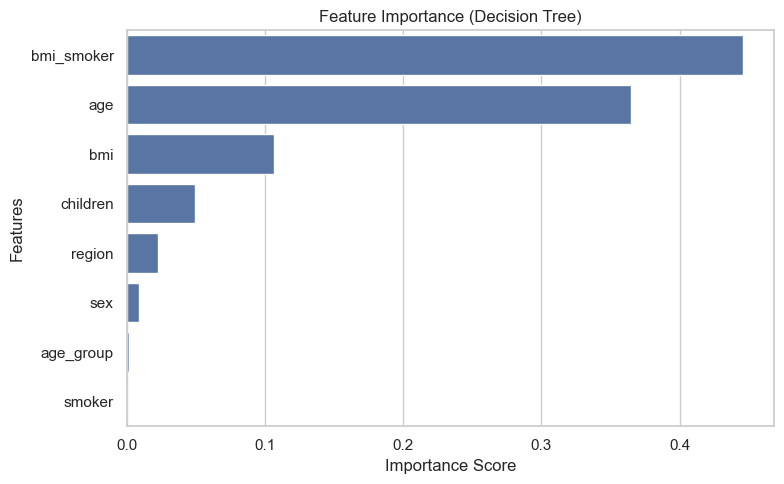

In [56]:
# Feature Importance using Decision Tree

# Train the model
tree = DecisionTreeRegressor(random_state=42)
tree.fit(X, y)

# Extract and plot importances
importances = pd.Series(tree.feature_importances_, index=X.columns).sort_values(ascending=False)

plt.figure(figsize=(8, 5))
sns.barplot(x=importances.values, y=importances.index)
plt.title('Feature Importance (Decision Tree)')
plt.xlabel('Importance Score')
plt.ylabel('Features')
plt.tight_layout()
plt.savefig(os.path.join(output_dir, "feature_importance.png"))
plt.show()

#### Reflection 2: 
- _What patterns or anomalies do you see?_
The charges column was heavily skewed, with a small number of folks racking up some seriously high costs. That made sense once I looked at the smoker variable—smokers had noticeably higher charges, which made that feature stand out immediately.

- Do any features stand out? What preprocessing steps were necessary to clean and improve the data? 
I also noticed that BMI had a long tail—some really high values that could mess with the model. 

- Did you create or modify any features to improve performance?
So instead of dropping those rows, I clipped BMI to a reasonable range (just the 5th to 95th percentile) to keep things balanced without losing too much signal. I used AI assistance to findd oput what to do with the BMI and charges.  Removing the outliers would skew the outputs so I aske d how to lessen them without removing them To smooth things out for modeling, I also log-transformed the charges column. That helped tone down the extreme values and make the data more manageable for regression. Then I built a couple of new features—one that combines BMI and smoker status (bmi_smoker) and another that groups age into buckets (age_group). Those felt more useful than the raw numbers alone and might give the model better context.

---

## Section 3. Feature Selection and Justification

### 3.1 Choose features and target
  - Select two or more input features (numerical for regression, numerical and/or categorical for classification)
  - Select a target variable (as applicable)
  - Regression: Continuous target variable (e.g., price, temperature).
  - Classification: Categorical target variable (e.g., gender, species).
  - Clustering: No target variable.
  - Justify your selection with reasoning.


### 3.2 Define X and y
  - Assign input features to X
  - Assign target variable to y (as applicable)


#### Reflection 3: 
  - Why did you choose these features? 
  - How might they impact predictions or accuracy?

---

## Section 4. Train a Model (Linear Regression)

### 4.1 Split the data into training and test sets using train_test_split (or StratifiedShuffleSplit if class imbalance is an issue).


### 4.2 Train model using Scikit-Learn model.fit() method

### 4.3 Evalulate performance, for example:
  - Regression: R^2, MAE, RMSE (RMSE has been recently updated)
  - Classification: Accuracy, Precision, Recall, F1-score, Confusion Matrix
  - Clustering: Inertia, Silhouette Score


#### Reflection 4: 
  -  How well did the model perform? 
  -  Any surprises in the results?

---

## Section 5. Improve the Model or Try Alternates (Implement Pipelines)


### 5.1 Implement Pipeline 1: Imputer → StandardScaler → Linear Regression.


### 5.2 Implement Pipeline 2: Imputer → Polynomial Features (degree=3) → StandardScaler → Linear Regression.


### 5.3 Compare performance of all models across the same performance metrics


#### Reflection 5: 
- Which models performed better?
- How does scaling impact results?

---

## Section 6. Final Thoughts & Insights


### 6.1 Summarize findings.


### 6.2 Discuss challenges faced.


### 6.3 If you had more time, what would you try next?


#### Reflection 6:
- What did you learn from this project?

---